### ET3112 Homework 8 on Alignment

D/ENG/21/0108/EE
MWM Shakir

_Question 1_

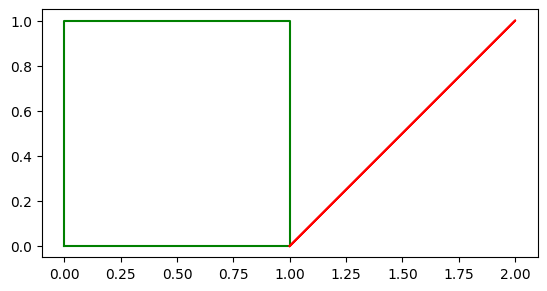

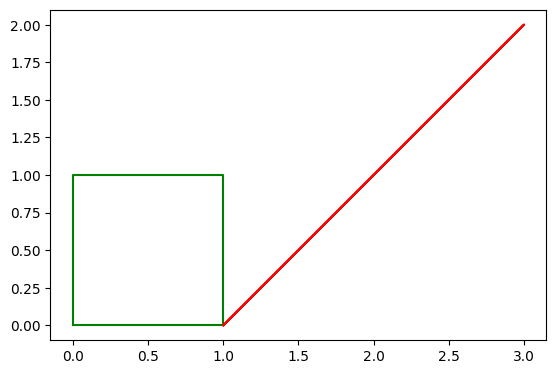

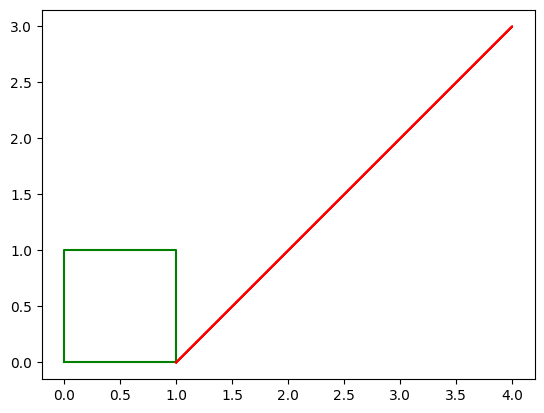

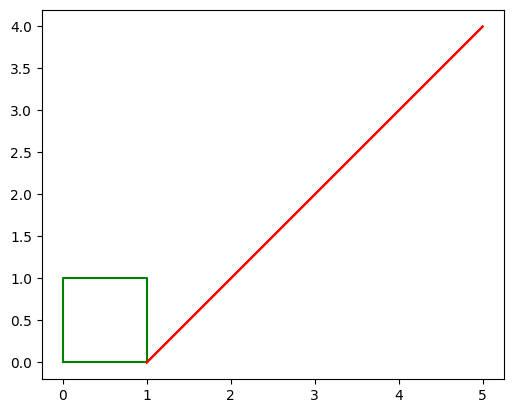

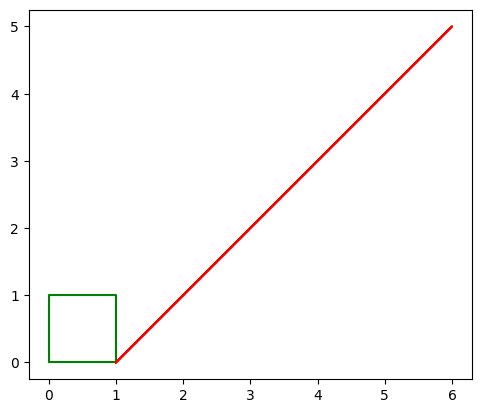

In [25]:
# Section 1
#http://ais.informatik.uni-freiburg.de/teaching/ws13/mapping/pdf/slam02-homegenous-4.pdf
import matplotlib.pyplot as plt
import numpy as np

# Points a, b, c, d
a, b, c, d = [0, 0, 1], [0, 1, 1], [1, 1, 1], [1, 0, 1]

X = np.array([a, b, c, d]).T #Transposes
# Y = X + np.array([3, 4, 1]).reshape(3,1) # transfromed version of X


t = np.array([1, 0]).T #starting position of transformed line

for i in range(5):
    i=1+i 
    A  = np.array([[0, i, t[0]], [0, i, t[1]], [0, 0, 1]]) # Affine transformaiton
    Y = A @ X
    # Homographic transformation

    x = np.append(X[0, :], X[0, 0])
    y = np.append(X[1, :], X[1, 0])
    fig, ax = plt.subplots(1,1)
    ax.plot(x, y, color='g')

    x = np.append(Y[0, :], Y[0, 0])
    y = np.append(Y[1, :], Y[1, 0])
    ax.plot(x, y, color='r')
    ax.set_aspect('equal')
    plt.show()

# more examples on https://docs.opencv.org/4.x/dd/d52/tutorial_js_geometric_transformations.html

_Question 2_

In [1]:
#  Section 2
# Transfroming the first image onto the second
# Gaffiti images: https://www.robots.ox.ac.uk/~vgg/data/affine/
import numpy as np
import cv2 as cv
im1 = cv.imread('graf/img1.ppm', cv.IMREAD_ANYCOLOR)
im2 = cv.imread('graf/img5.ppm', cv.IMREAD_ANYCOLOR)
assert im1 is not None
assert im2 is not None

# H = np.array([[8.7976964e-01,   3.1245438e-01,  -3.9430589e+01],
#   [-1.8389418e-01,   9.3847198e-01,   1.5315784e+02],
#    [1.9641425e-04,  -1.6015275e-05,   1.0000000e+00]])

with open('graf/H1to2p') as f:
   H = np.array([[float(h) for h in line.split()] for line in f])

im1to2 = cv.warpPerspective(im1, H, (1000,1000))

fig, ax
cv.namedWindow('Image 1', cv.WINDOW_AUTOSIZE)
cv.imshow('Image 1', im1)
cv.waitKey(0)
cv.namedWindow('Image 2', cv.WINDOW_AUTOSIZE)
cv.imshow('Image 2', im2)
cv.waitKey(0)
cv.namedWindow('Image 1 Warped', cv.WINDOW_AUTOSIZE)
cv.imshow('Image 1 Warped', im1to2)
cv.waitKey(0)
cv.destroyAllWindows()